In [1]:
import json
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import os
import pickle
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier,BaggingClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, chi2, RFECV
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC, LinearSVC, SVR

In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/krisk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
trainData = pd.read_csv('data/petfinder/train.csv')

In [4]:
trainData.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64


<AxesSubplot: >

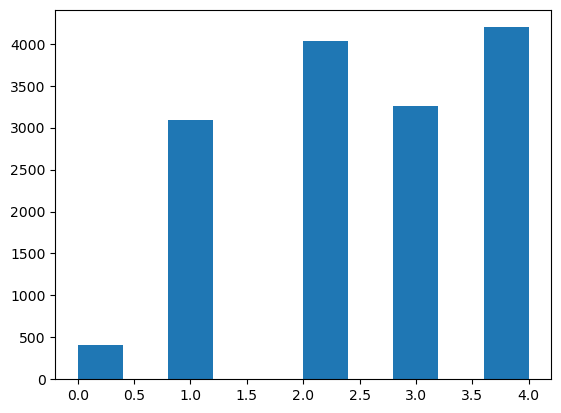

In [7]:
# Adoption speed label
print(trainData['AdoptionSpeed'].value_counts())
trainData['AdoptionSpeed'].hist(grid = False)

In [8]:
print("Total number of pets: ", len(trainData))
print("Total number of unnamed pets: ", sum(trainData['Name'].isna()))

Total number of pets:  14993
Total number of unnamed pets:  1257


In [9]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [10]:
# Convert description column to string.
trainData['Description'] = trainData['Description'].astype('string')

# Replace N/A by empty string.
trainData['Description'] = trainData['Description'].fillna ("")

# Add HasDescription column.
trainData['HasDescription'] = trainData['Description'] != ""

# Add DescriptionLength column.
trainData['DescriptionLength'] = [len(x) for x in trainData['Description']]

In [11]:
# Adding sentiment features for description.

# Get sentiment dataframe.
def get_description_sentiment_dataframe():

    ids = []
    sentiment_magnitudes = []
    sentiment_scores = []
    
    path = 'data/petfinder/train_sentiment'
    fileList = os.listdir(path)
    
    for filename in fileList:
        file = open(os.path.join(path + '/' + filename), 'r', encoding="utf8")
        
        sentiment = json.load(file)
        
        id = filename.split(".")[0]
        sentiment_magnitude = float(sentiment['documentSentiment']['magnitude'])
        sentiment_score = float(sentiment['documentSentiment']['score'])
        
        ids.append(id)
        sentiment_magnitudes.append(sentiment_magnitude)
        sentiment_scores.append(sentiment_score)
        
    d = {"id": ids, "sentiment_magnitude": sentiment_magnitudes, "sentiment_score": sentiment_scores }
    df = pd.DataFrame(d)
    
    return df
        
sentiment_df = get_description_sentiment_dataframe()
sentiment_df.head(10)

,id,sentiment_magnitude,sentiment_score
0,b5e7e4539,0.5,0.0
1,41e824cbe,8.3,0.2
2,0833744e6,2.9,0.3
3,fc229a9d7,1.7,0.4
4,3589a8a0d,0.9,0.9
5,bdfe6125d,0.7,0.3
6,57af29aba,1.1,0.3
7,94afcd90c,2.1,0.0
8,aa7dc1913,1.9,0.2
9,868dcd617,1.3,0.3


In [12]:
# Merging sentiment dataframe with main dataframe.
trainData = trainData.merge(sentiment_df, left_on='PetID', right_on='id', how='left')

In [14]:
# Adding sentiment product: (sentiment * magnitude) as a feature to dataframe.
trainData['SentimentProduct'] = trainData['sentiment_score']*trainData['sentiment_magnitude']

In [15]:
# Computing sentiment using NLTK's pre-trained analyzer.

def get_description_nltk_sentiment_analysis_dataframe():
    sia = SentimentIntensityAnalyzer()
    ids = trainData['PetID']
    descriptions = trainData['Description']
    
    negative_probs = []
    neutral_probs = []
    positive_probs = []
    compound_scores = []
    
    for description in descriptions:
        polarity_scores = sia.polarity_scores(description)
        
        negative_probs.append(polarity_scores['neg'])
        neutral_probs.append(polarity_scores['neu'])
        positive_probs.append(polarity_scores['pos'])
        compound_scores.append(polarity_scores['compound'])
    
    d = { "PetID": ids, "nltk_negative_prob": negative_probs, "nltk_neutral_prob": neutral_probs, \
          "nltk_positive_prob" : positive_probs, 'nltk_compound_score' : compound_scores}
    df = pd.DataFrame(d)
    
    return df
        
nltk_sentiment_df = get_description_nltk_sentiment_analysis_dataframe()

In [16]:
# Merge train dataframe with NLTK sentiment dataframe.
trainData = trainData.merge(nltk_sentiment_df, on='PetID', how='left')

trainData.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,HasDescription,DescriptionLength,id,sentiment_magnitude,sentiment_score,SentimentProduct,nltk_negative_prob,nltk_neutral_prob,nltk_positive_prob,nltk_compound_score
0,2,Nibble,3,299,0,1,1,7,0,1,...,True,359,86e1089a3,2.4,0.3,0.72,0.000,0.745,0.255,0.9552
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,True,118,6296e909a,0.7,-0.2,-0.14,0.149,0.723,0.129,0.1280
2,1,Brisco,1,307,0,1,2,7,0,2,...,True,393,3422e4906,3.7,0.2,0.74,0.095,0.706,0.200,0.7650
3,1,Miko,4,307,0,2,1,2,0,2,...,True,146,5842f1ff5,0.9,0.9,0.81,0.000,0.483,0.517,0.9538
4,1,Hunter,1,307,0,1,1,0,0,2,...,True,390,850a43f90,3.7,0.6,2.22,0.000,0.635,0.365,0.9880
5,2,NaN,3,266,0,2,5,6,0,2,...,True,87,d24c30b4b,0.2,0.0,0.00,0.000,1.000,0.000,0.0000
6,2,BULAT,12,264,264,1,1,0,0,2,...,True,400,1caa6fcdb,0.5,0.2,0.10,0.000,0.814,0.186,0.9116
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,True,109,97aa9eeac,0.9,0.1,0.09,0.000,0.818,0.182,0.4588
8,2,NaN,2,265,0,2,6,0,0,2,...,True,79,c06d167ca,0.5,0.1,0.05,0.113,0.576,0.311,0.5327
9,2,Kitty,12,265,0,2,1,7,0,2,...,True,232,7a0942d61,1.1,0.2,0.22,0.000,0.751,0.249,0.8916


In [17]:
# Merge train dataset with laplacian variance dataframe.
laplacian_df = pd.read_csv('data/petfinder/laplacian_variance.csv')
trainData = trainData.merge(laplacian_df, on='PetID', how='left')

trainData.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,DescriptionLength,id,sentiment_magnitude,sentiment_score,SentimentProduct,nltk_negative_prob,nltk_neutral_prob,nltk_positive_prob,nltk_compound_score,LaPlacianVariance
0,2,Nibble,3,299,0,1,1,7,0,1,...,359,86e1089a3,2.4,0.3,0.72,0.000,0.745,0.255,0.9552,672.771047
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,118,6296e909a,0.7,-0.2,-0.14,0.149,0.723,0.129,0.1280,454.006659
2,1,Brisco,1,307,0,1,2,7,0,2,...,393,3422e4906,3.7,0.2,0.74,0.095,0.706,0.200,0.7650,60.519822
3,1,Miko,4,307,0,2,1,2,0,2,...,146,5842f1ff5,0.9,0.9,0.81,0.000,0.483,0.517,0.9538,502.303825
4,1,Hunter,1,307,0,1,1,0,0,2,...,390,850a43f90,3.7,0.6,2.22,0.000,0.635,0.365,0.9880,363.978801
5,2,NaN,3,266,0,2,5,6,0,2,...,87,d24c30b4b,0.2,0.0,0.00,0.000,1.000,0.000,0.0000,809.205467
6,2,BULAT,12,264,264,1,1,0,0,2,...,400,1caa6fcdb,0.5,0.2,0.10,0.000,0.814,0.186,0.9116,132.502040
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,109,97aa9eeac,0.9,0.1,0.09,0.000,0.818,0.182,0.4588,24.170614
8,2,NaN,2,265,0,2,6,0,0,2,...,79,c06d167ca,0.5,0.1,0.05,0.113,0.576,0.311,0.5327,79.577436
9,2,Kitty,12,265,0,2,1,7,0,2,...,232,7a0942d61,1.1,0.2,0.22,0.000,0.751,0.249,0.8916,130.861890


In [19]:
# Merge train dataset with laplacian variance dataframe.
confidence_converage_df = pd.read_csv('data/img_coverage_conf.csv')
trainData = trainData.merge(confidence_converage_df, left_on='PetID', right_on='filename', how='left')

trainData.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,nltk_negative_prob,nltk_neutral_prob,nltk_positive_prob,nltk_compound_score,LaPlacianVariance,Unnamed: 0.1,Unnamed: 0,filename,confidence,coverage
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.000,0.745,0.255,0.9552,672.771047,11596.0,7596.0,86e1089a3,0.891234,10.053241
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.149,0.723,0.129,0.1280,454.006659,11313.0,7313.0,6296e909a,0.846251,68.934937
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.095,0.706,0.200,0.7650,60.519822,9023.0,5023.0,3422e4906,0.993825,80.775000
3,1,Miko,4,307,0,2,1,2,0,2,...,0.000,0.483,0.517,0.9538,502.303825,125.0,125.0,5842f1ff5,0.989233,77.653333
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.000,0.635,0.365,0.9880,363.978801,2559.0,2559.0,850a43f90,0.989775,30.327869
5,2,NaN,3,266,0,2,5,6,0,2,...,0.000,1.000,0.000,0.0000,809.205467,54800.0,12800.0,d24c30b4b,0.998554,34.859375
6,2,BULAT,12,264,264,1,1,0,0,2,...,0.000,0.814,0.186,0.9116,132.502040,8166.0,4166.0,1caa6fcdb,0.996223,44.998333
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,0.000,0.818,0.182,0.4588,24.170614,11144.0,7144.0,97aa9eeac,0.000000,0.000000
8,2,NaN,2,265,0,2,6,0,0,2,...,0.113,0.576,0.311,0.5327,79.577436,87.0,87.0,c06d167ca,0.991979,64.423333
9,2,Kitty,12,265,0,2,1,7,0,2,...,0.000,0.751,0.249,0.8916,130.861890,3755.0,3755.0,7a0942d61,0.951346,74.375000


In [21]:
trainData["confidence"].fillna(0, inplace = True)
trainData["coverage"].fillna(0, inplace = True)

In [22]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'HasDescription', 'DescriptionLength', 'id', 'sentiment_magnitude',
       'sentiment_score', 'SentimentProduct', 'nltk_negative_prob',
       'nltk_neutral_prob', 'nltk_positive_prob', 'nltk_compound_score',
       'LaPlacianVariance', 'Unnamed: 0.1', 'Unnamed: 0', 'filename',
       'confidence', 'coverage'],
      dtype='object')

In [23]:
categoricalFeatures = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', \
                       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', \
                       'Sterilized', 'Health', 'State']#, 'HasDescription']

numericalFeatures = ['Age', 'Quantity', 'Fee', 'VideoAmt',  'PhotoAmt', 'DescriptionLength',\
                    #'sentiment_magnitude', 'sentiment_score', 'SentimentProduct',\
                    'nltk_positive_prob', 'nltk_negative_prob', 'nltk_neutral_prob',\
                    'nltk_compound_score', 'LaPlacianVariance','confidence','coverage']

selectedCategoricalFeatures = ['Breed1', ]
selectedNumericalFeatures = ['Age', 'PhotoAmt', 'DescriptionLength',\
                             'nltk_positive_prob', 'nltk_negative_prob', 'nltk_neutral_prob', \
                             'nltk_compound_score']

features = categoricalFeatures + numericalFeatures
#features = selectedCategoricalFeatures + selectedNumericalFeatures

In [24]:
# Transforming columns.
labelEncoder = sklearn.preprocessing.LabelEncoder()
trainData['AdoptionSpeed'] = labelEncoder.fit_transform(trainData['AdoptionSpeed'])
    
# Transform features into categorical.
for c in categoricalFeatures:
        trainData[c] = trainData[c].astype('category')
        
# Transform features into float.
for c in numericalFeatures:
        trainData[c] = trainData[c].astype('float')
        
# Fill N/A values with zero for sentiment
trainData = trainData.fillna(value={'sentiment_magnitude': 1, 'sentiment_score': 1, 'SentimentProduct': 1, 'LaPlacianVariance' : 0})

In [25]:
# Splitting into train and test set.
x_train, x_test, y_train, y_test = train_test_split(trainData[features], trainData['AdoptionSpeed'], \
                                                    test_size=0.33, shuffle=True)

In [26]:
# Training a decision tree classifier for testing.
decisionTree = sklearn.tree.DecisionTreeClassifier(random_state=0)

decisionTree.fit(x_train, y_train)
        
decisionTreePredictions = decisionTree.predict(x_test)

print("F1 Score:", f1_score(y_test, decisionTreePredictions, average='macro'))
print("Accuracy Score:", accuracy_score(y_test, decisionTreePredictions))
print("Recall Score:", recall_score(y_test, decisionTreePredictions, average='macro'))

F1 Score: 0.26174124166845597
Accuracy Score: 0.31305578011317703
Recall Score: 0.2616358726799078


In [27]:
#Function for training a model.
def train_model(feature_selector, model):
    if feature_selector is not None:
        x_train_new = feature_selector.fit_transform(x_train, y_train)
    else:
        x_train_new = x_train
    #trained_model = Pipeline([
        #('feature_selection', SelectFromModel(estimator=sklearn.tree.DecisionTreeClassifier(random_state=0))),
        #('feature_selection', SelectFromModel(LinearSVC())),
        #('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=50))),
        #('feature_selection', SelectFromModel(sklearn.tree.DecisionTreeClassifier(random_state=0))),
    #    ('feature_selection', SelectFromModel(VarianceThreshold(threshold=(.8 * (1 - .8))).fit_transform(x_train,y_train))),
    #    ('classification', model)
    #])
    #trained_model.fit(x_new, y_train)
    model.fit(x_train_new, y_train)
    
    return model

# Function for training and outputing test results for a model.
def train_and_test_model(feature_selector, model):
    
    trained_model = train_model(feature_selector, model)
    
    if feature_selector is not None:
        x_test_new = feature_selector.transform(x_test)
    else:
        x_test_new = x_test

    predictions = trained_model.predict(x_test_new)
    
    print("F1 Score:", f1_score(y_test, predictions, average='macro'))
    print("Accuracy Score:", accuracy_score(y_test, predictions))
    print("Recall Score:", recall_score(y_test, predictions, average='macro'))
    
    if hasattr(trained_model, 'feature_importances_'):
        print("Feature Importances: ")
        for feature, importance in zip(features, trained_model.feature_importances_):
            print('feature: {f}, importance: {i}'.format(f=feature, i=importance))
    print()
    

# Function for training and outputing test results for a collection of models.
def train_and_test_model_collection(feature_selector, models):
    for model_name, model in models.items():
        print("Training and testing model:", model_name)
        train_and_test_model(feature_selector, model)
        print("=====")

In [28]:
# Training and testing multiple models.
#feature_selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
#feature_selector = SelectKBest(chi2, k=3)
#feature_selector = RFECV(SVR(kernel="linear"), step=1, cv=5)
feature_selector = None

model_collection = { 'Decision Tree' : sklearn.tree.DecisionTreeClassifier(random_state=0), \
                     'Support Vector Machine' : sklearn.svm.SVC(decision_function_shape='ovr'), \
                     'Bernoulli Naive Bayes' : BernoulliNB(), \
                     'Gaussian Naive Bayes' : GaussianNB(), \
                     'Multi-layer Perceptron Classifier' : MLPClassifier(random_state = 0), \
                     'KNN Classifier' : KNeighborsClassifier(n_neighbors=6), \
                     'Bagging Extra Tree Classifier' : BaggingClassifier(ExtraTreeClassifier(random_state=0), random_state=0), \
                     'Random Forest Classifier' : RandomForestClassifier(max_depth=20, random_state=0), \
                     'Gradient Boosting Classifier' : GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, \
                                                                                 max_depth=10, random_state=0), \
                     'Ada Boost Classifier' : AdaBoostClassifier(n_estimators=100, random_state=0),
                     'Bagging Classifier (Decision Trees)' : BaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(random_state=0), n_estimators=10, random_state=0)}

train_and_test_model_collection(feature_selector, model_collection)

Training and testing model: Decision Tree
F1 Score: 0.26174124166845597
Accuracy Score: 0.31305578011317703
Recall Score: 0.2616358726799078
Feature Importances: 
feature: Type, importance: 0.00042662874265973793
feature: Breed1, importance: 0.04291008300324916
feature: Breed2, importance: 0.02430181766708509
feature: Gender, importance: 0.014880438774447289
feature: Color1, importance: 0.029683813645392253
feature: Color2, importance: 0.030835911845423523
feature: Color3, importance: 0.013857944989831762
feature: MaturitySize, importance: 0.017357297223295542
feature: FurLength, importance: 0.01718962817585715
feature: Vaccinated, importance: 0.016526664341623414
feature: Dewormed, importance: 0.014769658980767045
feature: Sterilized, importance: 0.01453314629048802
feature: Health, importance: 0.0040622416344538725
feature: State, importance: 0.02758400277058293
feature: Age, importance: 0.05600652761801927
feature: Quantity, importance: 0.01695969984259429
feature: Fee, importance: 

In [29]:
# Utility function for saving a model with pickle.
def save_pickle_model(model_filename, model):
    pickle.dump(model, open(model_filename, 'wb'))

In [30]:
# Save a sample random forest classifier.
save_pickle_model("models/random_forest_classifier_kaggle.pkl", train_model(feature_selector, RandomForestClassifier(max_depth=20, random_state=0)))

In [31]:
# Plotting feature weights for Random Forest Classifier.
random_forest_classifier = RandomForestClassifier(max_depth=20, random_state=0)
trained_random_forest_classifier = train_model(feature_selector = None, model = random_forest_classifier)
print("Feature Importances: ")
for feature, importance in zip(features, trained_random_forest_classifier.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feature, i=importance))

Feature Importances: 
feature: Type, importance: 0.007204992466630762
feature: Breed1, importance: 0.04397519676424194
feature: Breed2, importance: 0.023650278056789473
feature: Gender, importance: 0.019610277625956303
feature: Color1, importance: 0.03099648890505391
feature: Color2, importance: 0.033418065993227775
feature: Color3, importance: 0.01646872232089084
feature: MaturitySize, importance: 0.018564685091598115
feature: FurLength, importance: 0.019001239134993665
feature: Vaccinated, importance: 0.016018371983064685
feature: Dewormed, importance: 0.01660565066776784
feature: Sterilized, importance: 0.02034527896732564
feature: Health, importance: 0.004172101125317303
feature: State, importance: 0.026000952256441452
feature: Age, importance: 0.06677155865383541
feature: Quantity, importance: 0.020583915618873252
feature: Fee, importance: 0.017221651727578516
feature: VideoAmt, importance: 0.004909200792618486
feature: PhotoAmt, importance: 0.05091960779713922
feature: Descriptio

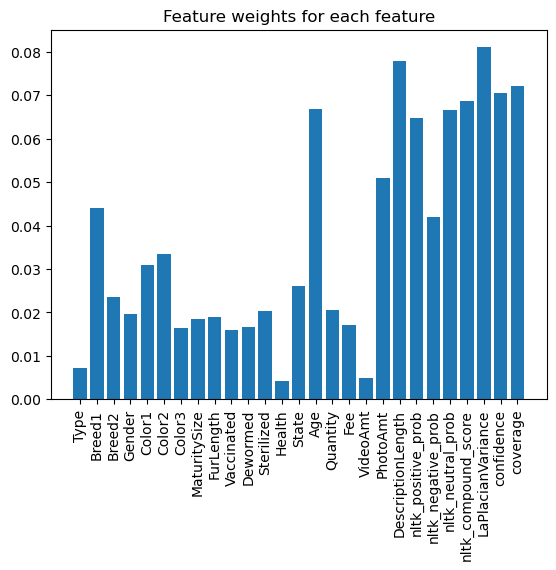

In [32]:
import matplotlib.pyplot as plt
plt.bar(features, trained_random_forest_classifier.feature_importances_)
plt.xticks(rotation='vertical')
plt.title("Feature weights for each feature")
plt.show()

In [33]:
# Detecting blurriness in images.
#!pip install opencv-python
import cv2
from IPython.display import Image, display

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

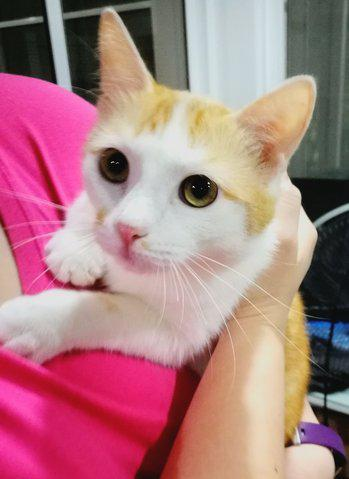

Laplacian Variance: 245.40164153508428


In [34]:
imagePath = "data/images/0008c5398-1.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)

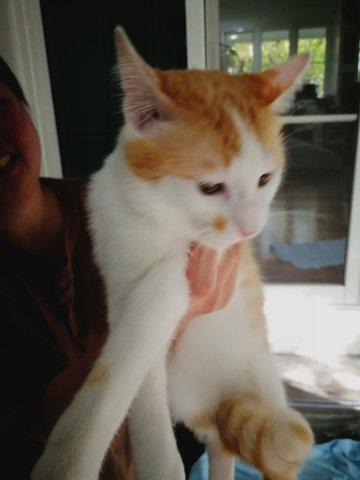

Laplacian Variance: 78.53132135252567


In [35]:
imagePath = "data/images/0008c5398-2.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)

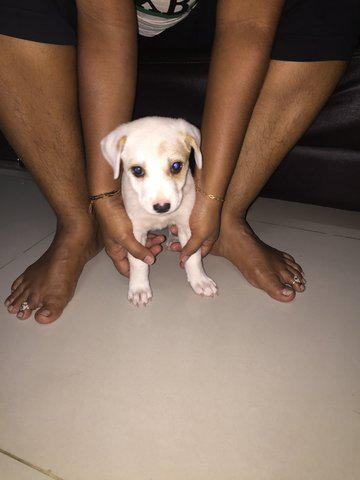

Laplacian Variance: 347.1344379725745


In [36]:
imagePath = "data/images/0038234c6-1.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)

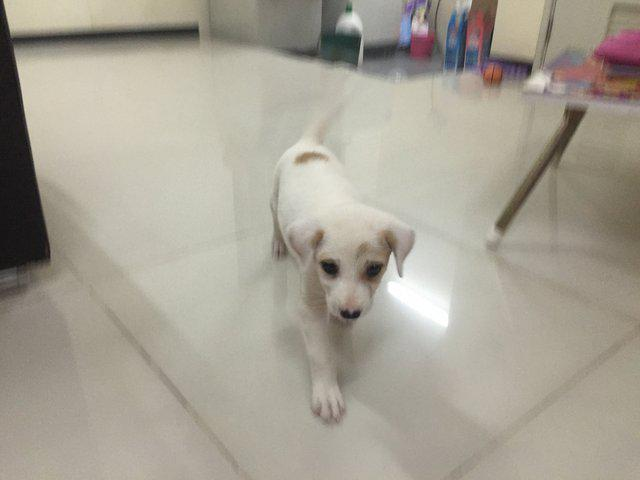

Laplacian Variance: 63.146722124566026


In [37]:
imagePath = "data/images/0038234c6-3.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)